# Credits
> This code is a slight modification to a translation (TensorFlow --> PyTorch) of a previous version of the [02456](http://kurser.dtu.dk/course/02456) course material. 
> [Original repo link (TensorFlow)](https://github.com/DeepLearningDTU/02456-deep-learning).
> [Translated repo link (PyTorch)](https://github.com/munkai/pytorch-tutorial/tree/master/2_intermediate).

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from torch.nn.parameter import Parameter
from torchvision.datasets import MNIST

# MNIST dataset
MNIST is a dataset that is often used for benchmarking. The MNIST dataset consists of 70,000 images of handwritten digits from 0-9. The dataset is split into a 50,000 images training set, 10,000 images validation set and 10,000 images test set. The images are 28x28 pixels, where each pixel represents a normalised value between 0-255 (0=black and 255=white).

![MNIST.Exampel](https://github.com/Ninaiskov/02456-deep-learning-with-PyTorch/blob/master/static_files/mnist.png?raw=1)


## Primer
We use a feedforward neural network to classify the 28x28 mnist images. `num_features` is therefore $28 * 28=784$, i.e. we represent each image as a vector. The ordering of the pixels in the vector does not matter, so we could permutate all images using the same permutation and still get the same performance. (You are of course encouraged to try this using ``numpy.random.permutation`` to get a random permutation. This task is therefore called the _permutation invariant_ MNIST. Obviously this throws away a lot of structure in the data. In the next module we'll fix this with the convolutional neural network wich encodes prior knowledgde about data that has either spatial or temporal structure.  

## MNIST
First let's load the MNIST dataset and plot a few examples:

In [2]:
mnist_trainset = MNIST("./temp/", train=True, download=True)
mnist_testset = MNIST("./temp/", train=False, download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./temp/MNIST/raw/train-images-idx3-ubyte.gz to ./temp/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./temp/MNIST/raw/train-labels-idx1-ubyte.gz to ./temp/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./temp/MNIST/raw/t10k-images-idx3-ubyte.gz to ./temp/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./temp/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./temp/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
# To speed up training we'll only work on a subset of the data
x_train = mnist_trainset.data[:1000].view(-1, 784).float()
targets_train = mnist_trainset.targets[:1000]

x_valid = mnist_trainset.data[1000:1500].view(-1, 784).float()
targets_valid = mnist_trainset.targets[1000:1500]

x_test = mnist_testset.data[:500].view(-1, 784).float()
targets_test = mnist_testset.targets[:500]

# normalize the inputs
x_train.div_(255)
x_valid.div_(255)
x_test.div_(255)

print("Information on dataset")
print("x_train", x_train.shape)
print("targets_train", targets_train.shape)
print("x_valid", x_valid.shape)
print("targets_valid", targets_valid.shape)
print("x_test", x_test.shape)
print("targets_test", targets_test.shape)

Information on dataset
x_train torch.Size([1000, 784])
targets_train torch.Size([1000])
x_valid torch.Size([500, 784])
targets_valid torch.Size([500])
x_test torch.Size([500, 784])
targets_test torch.Size([500])


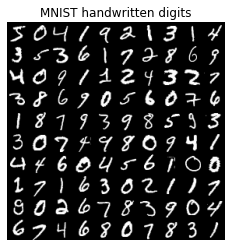

In [4]:
# plot a few MNIST examples
idx, dim, classes = 0, 28, 10
# create empty canvas
canvas = np.zeros((dim*classes, classes*dim))

# fill with tensors
for i in range(classes):
    for j in range(classes):
        canvas[i*dim:(i+1)*dim, j*dim:(j+1)*dim] = x_train[idx].reshape((dim, dim))
        idx += 1

# visualize matrix of tensors as gray scale image
plt.figure(figsize=(4, 4))
plt.axis('off')
plt.imshow(canvas, cmap='gray')
plt.title('MNIST handwritten digits')
plt.show()

## Model

One of the large challenges in deep learning is the amount of hyperparameters that needs to be selected, and the lack of a good principled way of selecting them.
Hyperparameters can be found by experience (guessing) or some search procedure (often quite slow).
Random search is easy to implement and performs decent: http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf . 
More advanced search procedures include [Spearmint](https://github.com/JasperSnoek/spearmint) and many others.

**In practice a lot of trial and error is almost always involved.** This can be frustrating and time consuming, but the best thing to do is to think as a scientist, and go about it in a ordered manner --> monitor as much as you can, take notes, and be deliberate!

Below are some guidelines that you can use as a starting point to some of the most important hyperparameters. 
(*regularization* is also very important, but will be covered later.)


### Ballpark estimates of hyperparameters
__Number of hidden units and network structure:__
You'll have to experiment. One rarely goes below 512 units for feedforward networks (unless your are training on CPU...).
There's some research into stochastic depth networks: https://arxiv.org/pdf/1603.09382v2.pdf, but in general this is trial and error.

__Parameter initialization:__
Parameter initialization is extremely important.
PyTorch has a lot of different initializers, check the [PyTorch API](http://pytorch.org/docs/master/nn.html#torch-nn-init). Often used initializer are
1. Kaiming He
2. Xavier Glorot
3. Uniform or Normal with small scale (0.1 - 0.01)
4. Orthogonal (this usually works very well for RNNs)

Bias is nearly always initialized to zero using the [torch.nn.init.constant(tensor, val)](http://pytorch.org/docs/master/nn.html#torch.nn.init.constant)

__Mini-batch size:__
Usually people use 16-256. Bigger is not allways better. With smaller mini-batch size you get more updates and your model might converge faster. Also small batch sizes use less memory, which means you can train a model with more parameters.

__Nonlinearity:__ [The most commonly used nonliearities are](http://pytorch.org/docs/master/nn.html#non-linear-activations)
1. ReLU
2. Leaky ReLU
3. ELU
3. Sigmoid (rarely, if ever, used in hidden layers anymore, squashes the output to the interval [0, 1] - appropriate if the targets are binary.
4. Tanh is similar to the sigmoid, but squashes to [-1, 1]. Rarely used any more.
4. Softmax normalizes the output to 1, useful if you have a multi-class classification problem.

See the plot below.

__Optimizer and learning rate:__
1. SGD + Momentum: learning rate 0.01 - 0.1 
2. ADAM: learning rate 3e-4 - 1e-5
3. RMSPROP: somewhere between SGD and ADAM


softmax should sum to one (approxiamtely): 1.0


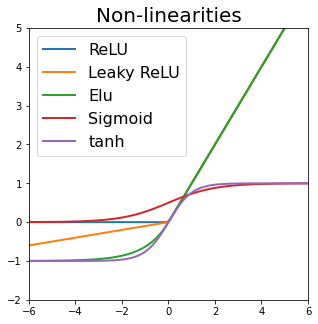

In [5]:
# Illustrate different output units
x = np.linspace(-6, 6, 100)
units = {
    "ReLU": lambda x: np.maximum(0, x),
    "Leaky ReLU": lambda x: np.maximum(0, x) + 0.1 * np.minimum(0, x),
    "Elu": lambda x: (x > 0) * x + (1 - (x > 0)) * (np.exp(x) - 1),
    "Sigmoid": lambda x: (1 + np.exp(-x))**(-1),
    "tanh": lambda x: (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))
}

plt.figure(figsize=(5, 5))
[plt.plot(x, unit(x), label=unit_name, lw=2) for unit_name, unit in units.items()]
plt.legend(loc=2, fontsize=16)
plt.title('Non-linearities', fontsize=20)
plt.ylim([-2, 5])
plt.xlim([-6, 6])

# assert that all class probablities sum to one
softmax = lambda x: np.exp(x) / np.sum(np.exp(x))
print("softmax should sum to one (approxiamtely):", np.sum(softmax(x)))

In [ ]:
#Hyperparameters
num_classes = 10
num_l1 = 512
num_features = x_train.shape[1]

# define network
class Net(nn.Module):

    def __init__(self, num_features, num_hidden, num_output):
        super(Net, self).__init__()  
        # input layer
        #self.W_1 = Parameter(init.xavier_normal_(torch.Tensor(num_hidden, num_features))) # with Xavier Glorot initialization
        self.W_1 = Parameter(init.kaiming_normal_(torch.Tensor(num_hidden, num_features))) # with Kaiming He initialization
        self.b_1 = Parameter(init.constant_(torch.Tensor(num_hidden), 0))
        # hidden layer 2 
        self.W_2 = Parameter(init.kaiming_normal_(torch.Tensor(num_hidden, num_hidden))) # with Kaiming He initialization
        self.b_2 = Parameter(init.constant_(torch.Tensor(num_hidden), 0))
        # hidden layer 2
        #self.W_3 = Parameter(init.xavier_normal_(torch.Tensor(num_output, num_hidden))) # with Xavier Glorot initialization
        self.W_3 = Parameter(init.kaiming_normal_(torch.Tensor(num_output, num_hidden))) # with Kaiming He initialization
        self.b_3 = Parameter(init.constant_(torch.Tensor(num_output), 0))
        # define activation function in constructor
        #self.activation = torch.nn.ELU() # ELU activation
        self.activation = torch.nn.ReLU() # ReLU activation
        self.dropout = torch.nn.Dropout(p=0.5) # dropout
        self.batchnorm1 = torch.nn.BatchNorm1d(num_features=num_hidden)
        self.batchnorm2 = torch.nn.BatchNorm1d(num_features=num_hidden)

    def forward(self, x):
        x = F.linear(x, self.W_1, self.b_1)
        #x = self.batchnorm1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = F.linear(x, self.W_2, self.b_2)
        #x = self.batchnorm2(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = F.linear(x, self.W_3, self.b_3)
        return x


net = Net(num_features, num_l1, num_classes)

In [ ]:
#optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9) # SGD optimizer
optimizer = optim.Adam(net.parameters(), lr=0.0001, weight_decay=1e-4) # ADAM optimizer
criterion = nn.CrossEntropyLoss()

In [ ]:
# Test the forward pass with dummy data
x = np.random.normal(0, 1, (45, dim*dim)).astype('float32')

print(net(torch.from_numpy(x)).size())

torch.Size([45, 10])


# Build the training loop

We train the network by calculating the gradient w.r.t the cost function and update the parameters in direction of the negative gradient. 


When training neural network you always use mini batches. Instead of calculating the average gradient using the entire dataset you approximate the gradient using a mini-batch of typically 16 to 256 samples. The paramters are updated after each mini batch. Networks converge much faster using mini batches because the parameters are updated more often.

We build a loop that iterates over the training data. Remember that the parameters are updated each time ``optimizer.step()`` is called.

Epoch  1 : Train Loss 0.261516 , Train acc 0.210000, Valid acc 0.222000
Epoch 11 : Train Loss 0.127676 , Train acc 0.826000, Valid acc 0.752000
Epoch 21 : Train Loss 0.072073 , Train acc 0.886000, Valid acc 0.798000
Epoch 31 : Train Loss 0.052910 , Train acc 0.921000, Valid acc 0.826000
Epoch 41 : Train Loss 0.038826 , Train acc 0.942000, Valid acc 0.844000
Epoch 51 : Train Loss 0.033369 , Train acc 0.958000, Valid acc 0.864000
Epoch 61 : Train Loss 0.025685 , Train acc 0.968000, Valid acc 0.876000
Epoch 71 : Train Loss 0.021771 , Train acc 0.980000, Valid acc 0.882000
Epoch 81 : Train Loss 0.019516 , Train acc 0.990000, Valid acc 0.878000
Epoch 91 : Train Loss 0.013447 , Train acc 0.995000, Valid acc 0.886000
Epoch 101 : Train Loss 0.012497 , Train acc 0.997000, Valid acc 0.882000
Epoch 111 : Train Loss 0.009842 , Train acc 0.997000, Valid acc 0.886000
Epoch 121 : Train Loss 0.008431 , Train acc 1.000000, Valid acc 0.884000
Epoch 131 : Train Loss 0.008304 , Train acc 1.000000, Valid a

(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'Acc'))

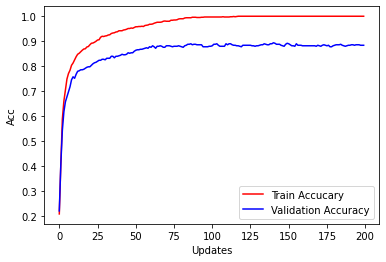

In [ ]:
# we could have done this ourselves,
# but we should be aware of sklearn and its tools
from sklearn.metrics import accuracy_score

# setting hyperparameters and gettings epoch sizes
batch_size = 100
num_epochs = 200
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        # compute gradients given loss
        target_batch = targets_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss   
    losses.append(cur_loss / batch_size)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        preds = torch.max(output, 1)[1]
        
        train_targs += list(targets_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(x_valid[slce])
        preds = torch.max(output, 1)[1]
        val_targs += list(targets_valid[slce].numpy())
        val_preds += list(preds.data.numpy())
        

    train_acc_cur = accuracy_score(train_targs, train_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    if epoch % 10 == 0:
        print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                epoch+1, losses[-1], train_acc_cur, valid_acc_cur))

epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('Acc')

# Assignments

Try and add these modifications (might require some Googleing -- an important skill in deep learning):
- Kaiming He initialization instead of Xavier Glorot
- add an extra layer
- use the relu activation function
- add momentum to the optimizer
- use the ADAM optimizer instead of stochastic gradient descent

### Advanced - Regularization

Regularization is VERY important in practice and is used practically every time.
Many important results are completely dependent on clever use of regularization, and it is something you need to become familiar with if you want to work with deep learning.

- add L1 or L2 weight regularization (aka. weight decay) 
- add dropout to the network (**note** the `net.train()` and `net.eval()` are already in the code)
- add batchnorm

__Pointers on regularization hyperparameter:__
1. L2 and [L1 regularization](http://pytorch.org/docs/master/nn.html#torch.nn.L1Loss) (weight decay of optimization functions) 
  - Normal ranges: 1e-4  -  1e-8
1. [Dropout](http://pytorch.org/docs/master/nn.html?highlight=dropout#torch.nn.Dropout). Dropout rate 0.1-0.5
  - Remember to pick the correct version according to the input dimensionality
  - **NOTE** call `net.train()` before training to activate random dropout, and call `net.eval()` to deactivate dropout while validating or running inference with model.
1. [Batchnorm](http://pytorch.org/docs/master/nn.html#torch.nn.BatchNorm1d): Batchnorm also acts as a regularizer - Often very useful (faster and better convergence)
  - Remember to pick the correct version according to the input dimensionality
  - **NOTE** call `net.train()` before training to activate, and call `net.eval()` to have a non-stochastic variant while validating or running inference with model.
    

#### Answer:
With Xavier Glorot initialization:
Epoch 191 : Train Loss 0.021658 , Train acc 0.953000, Valid acc 0.854000

With Kaiming He initialization:
Train Loss 0.021033 , Train acc 0.955000, Valid acc 0.856000

Extra hidden layer:
Train Loss 0.009058 , Train acc 0.993000, Valid acc 0.846000

Using ReLu activation:
Train Loss 0.009058 , Train acc 0.993000, Valid acc 0.846000

Using momentum in optimizer:
Train Loss 0.000233 , Train acc 1.000000, Valid acc 0.868000

Using ADAM:
Train Loss 0.000000 , Train acc 1.000000, Valid acc 0.868000

Using weight decay (in ADAM):
Train Loss 0.000055 , Train acc 1.000000, Valid acc 0.876000

Using dropout (20%):
Train Loss 0.000482 , Train acc 1.000000, Valid acc 0.888000

Using batchnormalization:
Train Loss 0.000482 , Train acc 1.000000, Valid acc 0.880000

Notes about regularization:
Large weights in a neural network are a sign of a more complex network that has overfit the training data. This network will be bad a generalizing to new data, thus the network is said to be unstable. A solution to this problem is to update the learning algorithm to encourage the network to keep the weights small. This is called weight regularization and it can be used as a general technique to reduce overfitting of the training dataset and improve the generalization of the model.

The regularization is done by adding the current size of all weights in the network to the loss. So the size of the weights are the penalty. The size of the weights can be estimated by either L1 or L2.

See here for more explanations
https://machinelearningmastery.com/weight-regularization-to-reduce-overfitting-of-deep-learning-models/

https://medium.com/analytics-vidhya/deep-learning-basics-weight-decay-3c68eb4344e9

You are done for now. [Good job.](https://media1.tenor.com/images/0fd559b07f2174f9b8b7dbde7c5a67ca/tenor.gif)

## Exercise from Michael Nielsen book
http://neuralnetworksanddeeplearning.com/

We just have to choose some random exercise from the book

#### Exercise from chapter 1:
Try creating a network with just two layers - an input and an output layer, no hidden layer - with 784 and 10 neurons, respectively. Train the network using stochastic gradient descent. What classification accuracy can you achieve?

In [13]:
#Hyperparameters
num_classes = 10
num_l1 = 0
num_features = x_train.shape[1] # 784

# define network
class Net(nn.Module):

    def __init__(self, num_features, num_hidden, num_output):
        super(Net, self).__init__()  
        # input layer
        self.W_1 = Parameter(init.kaiming_normal_(torch.Tensor(num_classes, num_features))) # with Kaiming He initialization
        self.b_1 = Parameter(init.constant_(torch.Tensor(num_classes), 0))

    def forward(self, x):
        x = F.linear(x, self.W_1, self.b_1) 
        # no activation since we only have input layer (no hidden layer)
        return x

net = Net(num_features, num_l1, num_classes)

In [14]:
optimizer = optim.SGD(net.parameters(), lr=0.01) # SGD optimizer
criterion = nn.CrossEntropyLoss()

In [15]:
# Test the forward pass with dummy data
x = np.random.normal(0, 1, (45, dim*dim)).astype('float32')

print(net(torch.from_numpy(x)).size())

torch.Size([45, 10])


Epoch  1 : Train Loss 0.234593 , Train acc 0.149000, Valid acc 0.166000
Epoch 11 : Train Loss 0.151566 , Train acc 0.704000, Valid acc 0.666000
Epoch 21 : Train Loss 0.114343 , Train acc 0.773000, Valid acc 0.746000
Epoch 31 : Train Loss 0.094577 , Train acc 0.816000, Valid acc 0.782000
Epoch 41 : Train Loss 0.082473 , Train acc 0.831000, Valid acc 0.792000
Epoch 51 : Train Loss 0.074253 , Train acc 0.841000, Valid acc 0.792000
Epoch 61 : Train Loss 0.068249 , Train acc 0.849000, Valid acc 0.792000
Epoch 71 : Train Loss 0.063629 , Train acc 0.862000, Valid acc 0.796000
Epoch 81 : Train Loss 0.059933 , Train acc 0.865000, Valid acc 0.804000
Epoch 91 : Train Loss 0.056887 , Train acc 0.870000, Valid acc 0.816000
Epoch 101 : Train Loss 0.054318 , Train acc 0.872000, Valid acc 0.820000
Epoch 111 : Train Loss 0.052110 , Train acc 0.880000, Valid acc 0.822000
Epoch 121 : Train Loss 0.050184 , Train acc 0.884000, Valid acc 0.826000
Epoch 131 : Train Loss 0.048482 , Train acc 0.888000, Valid a

(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'Acc'))

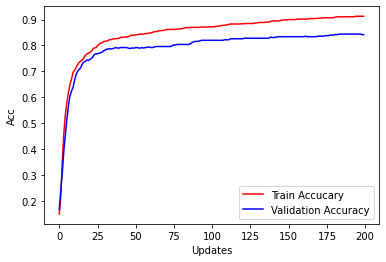

In [17]:
# we could have done this ourselves,
# but we should be aware of sklearn and its tools
from sklearn.metrics import accuracy_score

# setting hyperparameters and gettings epoch sizes
batch_size = 100
num_epochs = 200
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        # compute gradients given loss
        target_batch = targets_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss   
    losses.append(cur_loss / batch_size)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        preds = torch.max(output, 1)[1]
        
        train_targs += list(targets_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(x_valid[slce])
        preds = torch.max(output, 1)[1]
        val_targs += list(targets_valid[slce].numpy())
        val_preds += list(preds.data.numpy())
        

    train_acc_cur = accuracy_score(train_targs, train_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    if epoch % 10 == 0:
        print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                epoch+1, losses[-1], train_acc_cur, valid_acc_cur))

epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('Acc')